In [1]:
import sys
sys.path.append('/home/wwj/Repo/projects/respot')
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Parameter
from schnet import *

train = np.load('/home/wwj/data/ethanol_ccsd_t-train.npz')
test = np.load('/home/wwj/data/ethanol_ccsd_t-test.npz')

In [2]:
device = 0
n_atom = train.f.z.shape[0]
batch_size = 10
cutoff = 10.0 # no cutoff

In [3]:
n_gaussians = 64
n_filters = 64
n_atom_basis = 64


In [52]:
model = Net(n_atom_basis=n_atom_basis, n_filters=n_filters, n_gaussians=n_gaussians, cutoff= 10.0, device=device).to(device)

In [53]:
junk = Variable(torch.Tensor(train.f.z)).reshape(1, n_atom, 1).repeat(batch_size, 1, 1).cuda(device)
junk.requires_grad = True
junk_xyz = Variable(torch.Tensor(train.f.R[:batch_size])).cuda(device)
junk_xyz.requires_grad = True
f = model(r= junk, xyz=junk_xyz)#.shape
junk_force = compute_grad(inputs=junk_xyz, output=f)
print(f)
#f.sum().backward()
print(junk_force[0][5])

tensor([[4.0742],
        [4.1569],
        [4.1717],
        [4.2527],
        [3.9964],
        [4.0790],
        [4.0049],
        [4.1014],
        [4.2012],
        [4.1209]], device='cuda:0', grad_fn=<SumBackward1>)
tensor([-0.2195, -0.0363, -0.0289], device='cuda:0', grad_fn=<SelectBackward>)


In [54]:
N_train = train.f.E.shape[0]
N_test = test.f.E.shape[0]

#prepare data 
node_train = torch.Tensor([1,1,2,3,3,3,3,3,3]).reshape(1, n_atom, 1).repeat(batch_size, 1, 1)
xyz_train = torch.Tensor(train.f.R).reshape(-1, batch_size, n_atom, 3)
force_train = torch.Tensor(train.f.F).reshape(-1, batch_size, n_atom, 3)
energy_train = torch.Tensor(train.f.E).reshape(-1, batch_size, 1)

node_test = torch.Tensor([1,1,2,3,3,3,3,3,3]).reshape(1, n_atom,1).repeat(batch_size, 1, 1)
xyz_test = torch.Tensor(test.f.R).reshape(-1, batch_size, n_atom, 3)
force_test = torch.Tensor(test.f.F).reshape(-1, batch_size, n_atom, 3)
energy_test = torch.Tensor(test.f.E).reshape(-1, batch_size, 1)

In [55]:
xyz_train.shape[0]

100

In [56]:
# training/test loss log
test_u_log = []
train_u_log = []
test_f_log = []
train_f_log = []

In [57]:
# set up optimizer
optimizer = optim.Adam(list(model.parameters()), lr=1e-4) 
criterion = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

In [ ]:
for epoch in range(500):
    # train 
    train_u_mae = 0.0
    train_force_mae = 0.0
    
    for i, xyz in enumerate(xyz_train):
        
        node = Variable(torch.Tensor(node_train)).cuda(device)
        xyz = Variable(torch.Tensor(xyz)).cuda(device)
        xyz.requires_grad = True
        force = torch.Tensor(force_train[i]).cuda(device)
        energy = torch.Tensor(energy_train[i]).cuda(device)
        
        # predict energy and force 
        U = model(r=node, xyz=xyz)
        f_pred = -compute_grad(inputs=xyz, output=U)
        
        # comput eloss
        loss_force = criterion(f_pred, force)
        loss_u = criterion(U, energy)
        loss =  loss_force + 0.1*loss_u
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute MAE
        train_u_mae += mae(U, energy) # compute MAE
        train_force_mae += mae(f_pred, force)
        
    # averaging MAE
    train_u = train_u_mae.data[0]/(xyz_train.shape[0])
    train_force = train_force_mae.data[0]/(xyz_train.shape[0])
    
    train_u_log.append(train_u)
    train_f_log.append(train_force)
    # test 
    
    test_u_mae = 0.0
    test_force_mae = 0.0

    for i, xyz in enumerate(xyz_test):

        node = Variable(torch.Tensor(node_test), volatile=True).cuda(device)
        xyz = Variable(torch.Tensor(xyz)).cuda(device)
        xyz.requires_grad = True
        force = torch.Tensor(force_test[i]).cuda(device)
        energy = torch.Tensor(energy_test[i]).cuda(device)
        
        U = model(r=node, xyz=xyz)
        f_pred = -compute_grad(inputs=xyz, output=U)
        
        # loss
        test_u_mae += mae(U, energy) # compute MAE
        test_force_mae += mae(f_pred, force)
        
    # averaging MAE
    test_u = test_u_mae.data[0]/(xyz_test.shape[0])
    test_force = test_force_mae.data[0]/(xyz_test.shape[0])
    
    test_u_log.append(test_u)
    test_f_log.append(test_force)
    
    # check for convergence
    #if np.abs((np.array(test_u_log[-9: -5]).mean() - np.array(test_u_log[-5: -1:])).mean())/np.array(test_u_log[-9: -5]).mean() < 1e-4:
    #    print("converged!")
    #    break

    print("epoch %d  force train:  %.3f  U train: %.3f  force test:%.3f  U test: %.3f" % 
          (epoch, train_force, train_u, test_force, test_u))

/home/wwj/anaconda3/envs/MLMD/lib/python3.5/site-packages/ipykernel/__main__.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/wwj/anaconda3/envs/MLMD/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/wwj/anaconda3/envs/MLMD/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/wwj/anaconda3/envs/MLMD/lib/python3.5/site-packages/ipykernel/__main__.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/wwj/anaconda3/envs/MLMD/lib/python3.5/site-packages/ipykernel/__main__.py:60: UserWarning: invalid index of a 0-dim tensor.

epoch 0  force train:  20.699  U train: 97049.102  force test:20.846  U test: 96999.047
epoch 1  force train:  29.258  U train: 96799.070  force test:58.494  U test: 96411.156
epoch 2  force train:  202.810  U train: 95221.086  force test:457.727  U test: 93245.414
epoch 3  force train:  1056.974  U train: 88814.047  force test:1880.026  U test: 82422.125
epoch 4  force train:  3045.521  U train: 71572.391  force test:4253.883  U test: 58088.164
epoch 5  force train:  5267.960  U train: 42366.449  force test:5912.115  U test: 27221.312
epoch 6  force train:  6096.842  U train: 17917.080  force test:5934.587  U test: 11561.960
epoch 7  force train:  5762.409  U train: 9147.468  force test:5439.117  U test: 7494.175
epoch 8  force train:  5294.253  U train: 6656.793  force test:5042.833  U test: 5952.068
epoch 9  force train:  4937.293  U train: 5484.061  force test:4735.750  U test: 5057.354
epoch 10  force train:  4649.641  U train: 4736.553  force test:4475.635  U test: 4434.935
epoch

epoch 94  force train:  89.012  U train: 45.308  force test:87.095  U test: 37.453
epoch 95  force train:  86.954  U train: 43.673  force test:85.048  U test: 42.774
epoch 96  force train:  85.017  U train: 41.950  force test:83.131  U test: 46.290
epoch 97  force train:  83.199  U train: 40.224  force test:81.342  U test: 47.472
epoch 98  force train:  81.508  U train: 38.464  force test:79.681  U test: 46.213
epoch 99  force train:  79.947  U train: 36.825  force test:78.141  U test: 42.673
epoch 100  force train:  78.514  U train: 35.127  force test:76.719  U test: 37.444
epoch 101  force train:  77.206  U train: 33.418  force test:75.414  U test: 31.551
epoch 102  force train:  76.022  U train: 31.787  force test:74.209  U test: 26.271
epoch 103  force train:  74.950  U train: 30.230  force test:73.107  U test: 22.305
epoch 104  force train:  73.983  U train: 28.869  force test:72.106  U test: 19.707
epoch 105  force train:  73.109  U train: 27.840  force test:71.189  U test: 18.39

epoch 193  force train:  15.678  U train: 7.797  force test:15.113  U test: 5.865
epoch 194  force train:  15.489  U train: 7.801  force test:14.934  U test: 5.937
epoch 195  force train:  15.303  U train: 7.800  force test:14.755  U test: 5.994
epoch 196  force train:  15.121  U train: 7.798  force test:14.578  U test: 6.100
epoch 197  force train:  14.942  U train: 7.801  force test:14.403  U test: 6.157
epoch 198  force train:  14.767  U train: 7.801  force test:14.231  U test: 6.307
epoch 199  force train:  14.598  U train: 7.805  force test:14.063  U test: 6.469
epoch 200  force train:  14.436  U train: 7.810  force test:13.896  U test: 6.575
epoch 201  force train:  14.279  U train: 7.786  force test:13.730  U test: 6.722
epoch 202  force train:  14.129  U train: 7.798  force test:13.565  U test: 6.891
epoch 203  force train:  13.985  U train: 7.793  force test:13.404  U test: 7.007
epoch 204  force train:  13.846  U train: 7.777  force test:13.246  U test: 7.120
epoch 205  force

In [15]:
force[1]

tensor([[ 16.9428,  34.3376, -43.1913],
        [-37.0757, -15.2937, -22.6176],
        [-20.8500, -70.8308, -18.0372],
        [  5.3596,   1.5237,  35.4896],
        [-10.9207, -14.3460, -23.7980],
        [  9.1828,  19.7020,   4.2845],
        [-15.5365,  -0.9513,  12.6069],
        [ 20.9124,  -9.4956,  29.5358],
        [ 31.9853,  55.3542,  25.7275]], device='cuda:0')

In [16]:
f_pred[1]

tensor([[ 10.7119,  49.0557, -25.3447],
        [-42.2237, -16.7173, -39.5136],
        [-15.4135, -80.3331, -28.1890],
        [ -1.1730,  -7.5906,  35.8662],
        [-12.3059, -16.4615, -22.0254],
        [-21.8931,  20.7479,   3.6978],
        [ -5.5603,   0.4726,  24.7790],
        [ 28.5508, -10.1877,  20.0961],
        [ 59.3068,  61.0140,  30.6338]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [17]:
energy - U

tensor([[5.3359],
        [1.1641],
        [5.0703],
        [3.0859],
        [1.0625],
        [9.9922],
        [5.6016],
        [4.9922],
        [6.6172],
        [3.2422]], device='cuda:0', grad_fn=<ThSubBackward>)

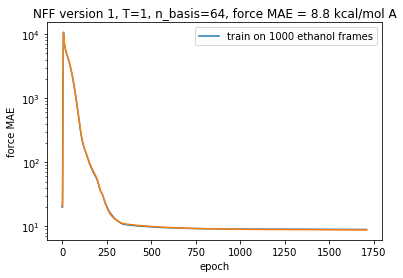

In [51]:
import matplotlib.pyplot as plt


#plt.text(1.0, 1.0, txt, ha='center')

plt.plot(test_f_log, label = "train on 1000 ethanol frames" )
plt.plot(train_f_log)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("force MAE")
plt.legend()
plt.title("NFF version 1, T=1, n_basis=64, force MAE = 8.8 kcal/mol A")
plt.show()

In [26]:
u_pred = []
for i, xyz in enumerate(xyz_test):

    node = torch.Tensor(node_test).to(device)
    xyz = torch.Tensor(xyz).to(device)
    energy = torch.Tensor(energy_test[i]).to(device)

    U = model(r=node, xyz=xyz)
    
    u_pred.append(U.detach().cpu().numpy())

In [41]:
u_pred = np.array(u_pred).reshape(-1)

In [38]:
energy_test.detach().numpy().reshape(-1)

array([-97088.53 , -97082.1  , -97078.05 , -97089.48 , -97084.51 ,
       -97080.78 , -97080.57 , -97091.086, -97090.75 , -97077.27 ,
       -97088.984, -97083.38 , -97082.53 , -97083.49 , -97086.89 ,
       -97087.4  , -97087.484, -97085.766, -97081.9  , -97086.27 ,
       -97091.875, -97087.4  , -97083.6  , -97092.66 , -97085.734,
       -97084.77 , -97089.69 , -97077.23 , -97089.96 , -97079.51 ,
       -97089.55 , -97090.03 , -97087.734, -97091.85 , -97089.01 ,
       -97082.14 , -97078.3  , -97086.31 , -97088.71 , -97092.72 ,
       -97081.87 , -97087.34 , -97085.45 , -97088.52 , -97090.3  ,
       -97078.31 , -97082.984, -97089.94 , -97085.3  , -97084.51 ,
       -97088.11 , -97088.59 , -97082.72 , -97088.75 , -97090.86 ,
       -97080.85 , -97075.13 , -97086.484, -97085.62 , -97084.945,
       -97087.13 , -97089.836, -97080.695, -97083.21 , -97083.52 ,
       -97088.86 , -97080.73 , -97066.375, -97086.914, -97083.74 ,
       -97088.734, -97083.086, -97091.31 , -97086.51 , -97081.

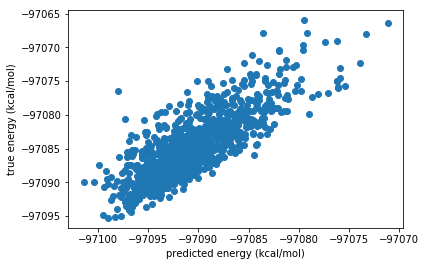

In [40]:
plt.scatter(u_pred, energy_test.detach().numpy().reshape(-1))

plt.ylabel("true energy (kcal/mol)")
plt.xlabel("predicted energy (kcal/mol)")

plt.show()